In [105]:
import cv2
import os
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import KFold
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical


In [106]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()#train = 60.000, test = 10.000 Datensätze



In [107]:
#Normalisierung der Pixel
x_train = x_train / 255.0
x_test = x_test / 255.0



In [108]:
#Beispiele, für Normalisierung erstellt
"""
img = cv2.imread("5.png")[:,:,0]
img = np.invert(np.array([img]))


dataframe1 = pd.DataFrame(img[0])
dataframe1.to_csv("nicht-normalisiert.csv")



img = img / 255.0
plt.figure(figsize=(28,28)) 
sn.heatmap(img[0], annot= True, cmap="binary")


dataframe2 = pd.DataFrame(img[0])
dataframe2.to_csv("normalisiert.csv")
"""

'\nimg = cv2.imread("5.png")[:,:,0]\nimg = np.invert(np.array([img]))\n\n\ndataframe1 = pd.DataFrame(img[0])\ndataframe1.to_csv("nicht-normalisiert.csv")\n\n\n\nimg = img / 255.0\nplt.figure(figsize=(28,28)) \nsn.heatmap(img[0], annot= True, cmap="binary")\n\n\ndataframe2 = pd.DataFrame(img[0])\ndataframe2.to_csv("normalisiert.csv")\n'

In [180]:

def Modell_definieren():
    model = tf.keras.models.Sequential()
    #Convolutional Layer, Pixel nach Conv: 26x26          #width, height, channel (Farbe)
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1))) # 32 filters, 3,3 = Kernel Size zeigt die größe des Filters höhe x Breite
    #Pooling Layer Pixel nach Maxpooling: 13x13
    model.add(MaxPooling2D((2, 2)))
    #Flatten Layer nach Flatten = 169 Eingabe in Neuronen
    model.add(tf.keras.layers.Flatten())#Matrix als Liste umwandeln
    #Hidden Neuron Layer
    model.add(tf.keras.layers.Dense(169, activation='relu')) #Rectified Linear Unit activation function.
    model.add(tf.keras.layers.Dense(169, activation='relu'))# 169 Neuronen, zwei Neuronen Layer, bei 3 war es schlechter, bei 1 auch schlechter.
    #Output Layer
    model.add(tf.keras.layers.Dense(10, activation='softmax')) #alle zusammen = 1 jedes neuron hat eine Zahl zwischen 0 und 1, Softmax = Winner takes it all
    #andere sind = argmax gibt den Indsex an, der den größten Wert besitzt
    #max gibt den größten Wert zurück
                                            #Loss Function, Berechnung der Größe des Losses
    model.compile(optimizer = 'adam', loss='sparse_categorical_crossentropy', metrics =['accuracy'])
    
    #model.fit(x_train, y_train, epochs= 9) # 9 Epochen, bei 10 Epochen war eine schelchtere Accuracy, bis 9 ist die Accuracy besser geworden und die Loss weniger
    #model.save('handwritten.model')
    return model



In [184]:

#Funktion für die Kreuzvalidierung
def Modell_evaluieren(dataX, dataY, n_folds=2):#Anzahl der Kreuzvalidierungen
	scores, histories = list(), list()
	
	kfold = KFold(n_folds, shuffle=True, random_state=1)#Shuffel = Trainigsdaten mischen bevor in Training und Test aufteilen. 
	
	for train_ix, test_ix in kfold.split(dataX):
		
		model = Modell_definieren()
		
		x_train, y_train, x_test, y_test = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		                                                                                               
		history = model.fit(x_train, y_train, epochs=12, batch_size=32, validation_data=(x_test, y_test))#Batch Size, definieren der größe die durch das Neuronale Netz laufen
		model.save('handwritten.model')
		_, acc = model.evaluate(x_test, y_test, verbose=0)
		print('> %.3f' % (acc * 100.0))
		
		scores.append(acc)
		histories.append(history)
  		
	return scores, histories

In [182]:
#Plot der diagnostics
def Diagnose_zusammenfassen(histories):
	for i in range(len(histories)):
		# plot des losses
		plt.subplot(2, 1, 1)
		plt.title('Cross Entropy Loss')
		plt.plot(histories[i].history['loss'], color='blue', label='train')
		plt.plot(histories[i].history['val_loss'], color='orange', label='test')
		# Acurracy Ausgeben
		plt.subplot(2, 1, 2)
		plt.title('Classification Accuracy')
		plt.plot(histories[i].history['accuracy'], color='blue', label='train')
		plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
		plt.tight_layout(pad=1.5)
	plt.show

In [196]:
scores, histories = Modell_evaluieren(x_train, y_train)
Diagnose_zusammenfassen(histories)

In [197]:
#Durchführen, falls das Model nicht erneuet trainiert werden soll, Lädt das bereits trainierte Modell neu ein
model = tf.keras.models.load_model('handwritten.model') # Laden des Models
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 7ms/step - loss: 0.0864 - accuracy: 0.9828


[0.08644988387823105, 0.9828000068664551]

In [174]:
#Erzeugen der Funktion, damit eine PNG mit 28x28 Größe die Zahl predicted werden kann.
def Handschrifterkennung(path): 
 img = cv2.imread(path)[:,:,0]#Einlesen, da sonst Dimensionen bei der Prediction einen Fehler werfen
 img = np.invert(np.array([img]))
 prediction = model.predict(img)
 print("Neuronen Aktivierung: ", prediction[0])
 plt.imshow(img[0])
 plt.show()
 print("Die Vorhersage lautet: " , np.argmax(prediction))#np.argmax zeigt die Index stelle des Arrays an, die auch in dem Neuronen Array aktiviert ist
 



313/313 [==============================] - 2s 6ms/step
1


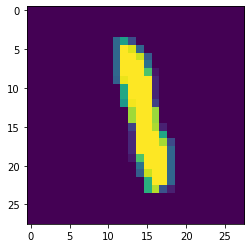

In [175]:
#Bild 322 des x_test predicten
predictions = model.predict(x_test)
print(np.argmax(predictions[350]))
plt.imshow(x_test[350])
plt.show()


1/1 [==============================] - 0s 26ms/step
Neuronen Aktivierung:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]


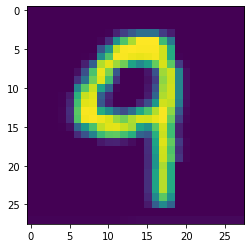

Die Vorhersage lautet:  9


In [194]:
#9 Richtig vorhergesagt
Handschrifterkennung("leicht.png")

1/1 [==============================] - 0s 25ms/step
Neuronen Aktivierung:  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


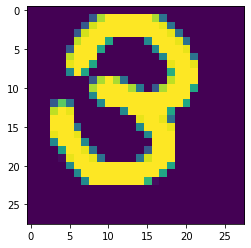

Die Vorhersage lautet:  3


In [195]:
#9 Falsch vorhergesagt
Handschrifterkennung("mittel.png")

1/1 [==============================] - 0s 75ms/step
Neuronen Aktivierung:  [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


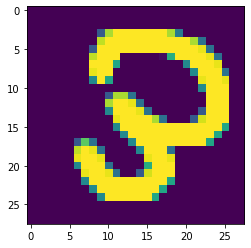

Die Vorhersage lautet:  6


In [198]:
#live
Handschrifterkennung("schwer.png")

Text(69.0, 0.5, 'Tatsächlicher Wert')

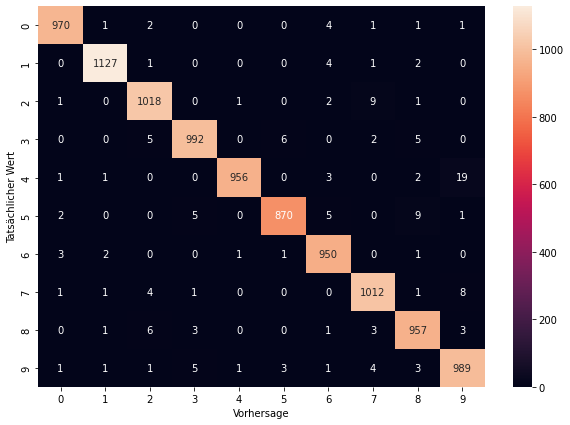

In [179]:
#Confusionsmatrix erstellen über den x_test Datensatz
prediction_labels = [np.argmax(i) for i in predictions]

confusionmatrix = tf.math.confusion_matrix(labels=y_test, predictions=prediction_labels)

plt.figure(figsize = (10, 7))
sn.heatmap(confusionmatrix, annot=True, fmt='d')
plt.xlabel('Vorhersage')
plt.ylabel('Tatsächlicher Wert')